In [1]:
import sys
import os
import yaml
import tensorflow as tf
import pandas as pd
import numpy as np
import netCDF4 as nc
from os.path import exists, join
from goes16ci.data import load_data_serial
from goes16ci.models import train_conv_net_cpu, train_conv_net_gpu, MinMaxScaler2D, StandardScaler2D, seed_everything
from goes16ci.monitor import Monitor, start_timing, end_timing, get_gpu_names, get_gpu_topo, get_cuda_version, get_cudnn_version, get_nccl_version
import argparse
import logging
from datetime import datetime
import platform
from multiprocessing import Pipe, Process
import traceback
import pickle
from sklearn.utils import class_weight
from os import listdir
from os.path import isfile, join
import time
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from time import perf_counter
import matplotlib.pyplot as plt
from keras import backend as K
import scipy.io as scio
from scipy import stats
from echo.src.base_objective import BaseObjective
from echo.src.pruners import KerasPruningCallback
sys.path.append('/glade/work/fanda/optimization/echo_opt')
sys.path.append('/glade/work/fanda/util/goes16ci/goes16ci')
sys.path.append('/glade/work/fanda/util/ams-ml-python-course')
#from models_test import train_conv_net_cpu, train_conv_net_gpu, MinMaxScaler2D
import optuna
gpus = tf.config.get_visible_devices("GPU")
for device in gpus:
    print(device)
    tf.config.experimental.set_memory_growth(device, True)

2023-12-01 07:07:45.759929: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Using TensorFlow backend.
2023-12-01 07:08:41.475722: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-12-01 07:08:41.488454: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-12-01 07:08:41.791236: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-12-01 07:08:41.791307: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (crhtc26): /proc/driver/nvidia/version does not exist


In [2]:
# Load test data
import scipy.io as scio
test_data = scio.loadmat('/glade/work/fanda/test_data/test_lead10.mat')
test_data_scaled=test_data["test_data_scaled"]
test_label=test_data["test_label"][0,:]

# Load resnet model
i = 0
resnet = tf.keras.models.load_model("/glade/work/fanda/echo_resnet_lead_time/"+str(10*(i+1))+"min/goes16_resnet_gpus_01.h5",compile=False)

# Load logistic model
with open('/glade/work/fanda/echo_log_lead_time/10min/Logistic_regression_optimal.pkl', 'rb') as f:
    log = pickle.load(f)

2023-12-01 07:08:42.486525: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-01 07:08:42.487011: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


In [ ]:
print(resnet.summary())

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import Tensor
from tensorflow import keras
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, ReLU, LeakyReLU, BatchNormalization, MaxPooling2D,\
                                    Add, AveragePooling2D, Flatten, Dense, Dropout, Activation
from keras.layers.merge import concatenate
#inputs = keras.Input(shape=(32, 32, 7), name="scn_input")

config_file = open('/glade/work/fanda/optimization/benchmark_config_default_echo_best_resnet.yml',"r")
config = yaml.load(config_file, Loader=yaml.Loader)
# Define posterior
kernel_posterior_scale_mean=-9.0,
kernel_posterior_scale_stddev=0.1,
kernel_posterior_scale_constraint=0.2

leaky_alpha = config['conv_net_parameters']['leaky_alpha']
dropout_alpha = config['conv_net_parameters']['dropout_alpha']

def get_kernel_posterior_fn(kernel_posterior_scale_mean=-9.0,
                                kernel_posterior_scale_stddev=0.1,
                                kernel_posterior_scale_constraint=0.2):
    """
    Get the kernel posterior distribution
    # Arguments
        kernel_posterior_scale_mean (float): kernel posterior's scale mean.
        kernel_posterior_scale_stddev (float): the initial kernel posterior's scale stddev.
            ```
            q(W|x) ~ N(mu, var),
            log_var ~ N(kernel_posterior_scale_mean, kernel_posterior_scale_stddev)
            ````
        kernel_posterior_scale_constraint (float): the log value to constrain the log variance throughout training.
            i.e. log_var <= log(kernel_posterior_scale_constraint).
    # Returns
        kernel_posterior_fn: kernel posterior distribution
    """

    def _untransformed_scale_constraint(t):
        return tf.clip_by_value(t, -1000, tf.math.log(kernel_posterior_scale_constraint))

    kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn(
        untransformed_scale_initializer=tf.random_normal_initializer(
            mean=kernel_posterior_scale_mean,
            stddev=kernel_posterior_scale_stddev),
        untransformed_scale_constraint=_untransformed_scale_constraint)
    return kernel_posterior_fn

def get_kernel_divergence_fn(train_size, w=1.0):
    """
    Get the kernel Kullback-Leibler divergence function
    # Arguments
        train_size (int): size of the training dataset for normalization
        w (float): weight to the function
    # Returns
        kernel_divergence_fn: kernel Kullback-Leibler divergence function
    """

    def kernel_divergence_fn(q, p, _):  # need the third ignorable argument
        kernel_divergence = tfp.distributions.kl_divergence(q, p) / tf.cast(train_size, tf.float32)
        return w * kernel_divergence

    return kernel_divergence_fn
    
# Convert weights into probability distribution
def conv(n_filter, n_kernel, strides, inputs):
    conv1 = tfp.layers.Convolution2DFlipout(n_filter, n_kernel, strides=strides, padding="same", kernel_posterior_fn=get_kernel_posterior_fn(), kernel_divergence_fn=None, data_format="channels_last") #kernel_divergence_fn=None, 
    w = conv1.add_weight(name=conv1.name + '/kl_loss_weight', initializer=tf.initializers.constant(1.0), trainable=False)
    conv1.kernel_divergence_fn = get_kernel_divergence_fn(config['conv_net_parameters']['batch_size'], w)  
    #w = conv1.add_weight(name=conv1.name+'/kl_loss_weight', shape=(), initializer=tf.initializers.constant(0.0), trainable=False)
    #conv1.kernel_divergence_fn = get_kernel_divergence_fn(train_size, w)
    return conv1(inputs)

def relu_bn_drop(inputs):
    relu = LeakyReLU(alpha=leaky_alpha)(inputs)#relu = ReLU()(bn)
    bn = BatchNormalization(-1)(relu)
    drop = Dropout(dropout_alpha)(bn)
    return drop

def residual_block(x, downsample, filters, kernel_size=3, broader=False):
#def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    '''
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same", data_format="channels_last")(x)
    '''
    y = conv(filters, kernel_size, 1 if not downsample else 2, x)
    y = relu_bn_drop(y)
    y = conv(filters, kernel_size, 1, y)
    '''
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same", data_format="channels_last")(y)
    '''
    if downsample:
        x = conv(filters, 1, 2, x)
        '''
        x = Conv2D(kernel_size=1,
           strides=2,
           filters=filters,
           padding="same")(x)
        '''
    out = Add()([y, x])
    out = relu_bn_drop(out)
    return out

def create_res_net():
    inputs = Input(shape=(32, 32, 7))
    num_filters = 64 #64
    x = conv(num_filters, 7, 1, inputs)
    '''
    x = Conv2D(kernel_size=7,
           strides=1,
           filters=num_filters,
           padding="same", data_format="channels_last")(inputs)
    '''
    t = relu_bn_drop(x)
    num_blocks_list = [2, 2, 2]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
        num_filters *= 2
    
    t = AveragePooling2D(padding="same", data_format="channels_last")(t)
    t = Flatten()(t)
    dense1 = tfp.layers.DenseFlipout(
        1024,
        kernel_posterior_fn=get_kernel_posterior_fn(),
        kernel_divergence_fn=None)#kernel_divergence_fn=None
    #w10 = dense1.add_weight(name=dense.name+'/kl_loss_weight', shape=(), initializer=tf.initializers.constant(0.0), trainable=False)
    #dense1.kernel_divergence_fn = get_kernel_divergence_fn(train_size, w10)
    w = dense1.add_weight(name = dense1.name+'/kl_loss_weight', shape=(), initializer=tf.initializers.constant(1.0), trainable=False)
    dense1.kernel_divergence_fn = get_kernel_divergence_fn(config['conv_net_parameters']['batch_size'], w)
    t = dense1(t)
    dense2 = tfp.layers.DenseFlipout(
        1,
        kernel_posterior_fn=get_kernel_posterior_fn(),
        activation='sigmoid',
        kernel_divergence_fn=None)#, activation='sigmoid'
    w = dense2.add_weight(name = dense2.name+'/kl_loss_weight', shape=(), initializer=tf.initializers.constant(1.0), trainable=False)
    dense2.kernel_divergence_fn = get_kernel_divergence_fn(config['conv_net_parameters']['batch_size'], w)
    outputs = dense2(t)
    '''
    t = Dense(1024)(t)
    t = Dense(1)(t)
    '''
    #outputs = Activation("sigmoid")(t)#Activation("linear")(t)
    model = Model(inputs, outputs)
    return model

In [4]:
# Flattened test data for logistic model
test_data_scaled_flatten = test_data_scaled.reshape((-1,7168))

In [5]:
resnet_preds = resnet.predict(test_data_scaled)[:,0]
log_preds = log.predict_proba(test_data_scaled_flatten)[:,1]

2023-12-01 07:09:13.057299: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-12-01 07:09:13.076141: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2600000000 Hz


In [6]:
model_binary_cross_entropy = create_res_net()
model_binary_cross_entropy.load_weights("/glade/work/fanda/model_save/goes16_resnet_bnn_binary_cross_entropy.h5")
model_ELBO = create_res_net()
model_ELBO.load_weights("/glade/work/fanda/model_save/goes16_resnet_bnn_elbo_10len_AUC846.h5")

In [41]:
Bayesian_resnet_preds_bce = model_binary_cross_entropy.predict(test_data_scaled)[:,0]
Bayesian_resnet_preds_ELBO = model_ELBO.predict(test_data_scaled)[:,0]

In [8]:
Bayesian_resnet_preds_ELB1 = Bayesian_resnet_preds_ELBO
Bayesian_resnet_preds_ELBO = model_ELBO.predict(test_data_scaled)[:,0]
print(np.sum(np.abs(Bayesian_resnet_preds_ELB1-Bayesian_resnet_preds_ELBO)))

2016.0388


In [18]:
import time

T = 100 #00
Bayesian_resnet_preds_bce_mean = np.zeros(len(test_data_scaled))
start = time.time()
for i in range(T):
    Bayesian_resnet_preds_bce = model_binary_cross_entropy.predict(test_data_scaled)[:,0]
    Bayesian_resnet_preds_bce_mean += Bayesian_resnet_preds_bce
end = time.time()
print('Elapsed time is {}s'.format(end - start))
Bayesian_resnet_preds_bce_mean = Bayesian_resnet_preds_bce_mean/T

Elapsed time is 1028.8889939785004s


In [35]:
import time
import multiprocessing as mp
from multiprocessing import Pool, Manager, Value, Array, Lock

def run_bayesian(test_data):
    Bayesian_resnet_preds_ELBO = model_ELBO.predict(test_data)[:,0]
    print('done')
    return Bayesian_resnet_preds_ELBO

T = 100 #00
Bayesian_resnet_preds_ELBO_mean = np.zeros(len(test_data_scaled))
Bayesian_resnet_preds_ELBO_all = np.zeros((len(test_data_scaled),T))
start = time.time()
'''
pool = Pool(mp.cpu_count())
results = [pool.apply_async(run_bayesian, (test_data_scaled,)) for i in range(T)]
for result in results:
    res = result.get()
    if res is not False:
        Bayesian_resnet_preds_ELBO_mean += res
        print(res.shape)
pool.close()
pool.join()
pool.terminate()
end = time.time()
print('Elapsed time is {}s'.format(end - start))
'''
for i in range(T):
    Bayesian_resnet_preds_ELBO = model_ELBO.predict(test_data_scaled)[:,0]
    Bayesian_resnet_preds_ELBO_all[:,i] = Bayesian_resnet_preds_ELBO
    Bayesian_resnet_preds_ELBO_mean += Bayesian_resnet_preds_ELBO
end = time.time()
print('Elapsed time is {}s'.format(end - start))
Bayesian_resnet_preds_ELBO_mean = Bayesian_resnet_preds_ELBO_mean/T

Elapsed time is 1049.1223409175873s


In [86]:
def entropy(p):
    return -(np.log2(p)*p+np.log2(1-p)*(1-p))

def entropy_weight(p):
    entropy_all = entropy(p)
    reverse_entropy = 1/entropy_all
    for i in range(len(reverse_entropy)):
        reverse_entropy[i][reverse_entropy[i]<0.8*np.mean(reverse_entropy[i])] = 0
    total_weight = np.sum(reverse_entropy, axis=1)
    return reverse_entropy/total_weight[:, np.newaxis]

def variance(p):
    return p*(1-p)

def var_weight(p):
    var_all = variance(p)
    total_weight = np.sum(1/var_all, axis=1)
    return 1/(var_all*total_weight[:, np.newaxis])

Bayesian_resnet_preds_ELBO_weighted_mean = np.sum(entropy_weight(Bayesian_resnet_preds_ELBO_all)*Bayesian_resnet_preds_ELBO_all,axis=1)
#Bayesian_resnet_preds_ELBO_weighted_mean = np.sum(var_weight(Bayesian_resnet_preds_ELBO_all)*Bayesian_resnet_preds_ELBO_all,axis=1)

In [75]:
entropy(0.5)

-1.0

In [82]:
np.min(Bayesian_resnet_preds_ELBO_weighted_mean)

0.00028878365119602037

In [88]:
import scipy.io as scio
#scio.savemat('/glade/work/fanda/output_save/prediction_bayesian_resnet_KLweight_ten_len_train.mat',{'Bayesian_resnet_preds_ELBO_mean':Bayesian_resnet_preds_ELBO_mean})
scio.savemat('/glade/work/fanda/output_save/prediction_bayesian_resnet_KLweight_ten_len_train_ensemble.mat',{'Bayesian_resnet_preds_ELBO_weighted_mean':Bayesian_resnet_preds_ELBO_weighted_mean})

In [19]:
import scipy.io as scio
scio.savemat('/glade/work/fanda/output_save/prediction_bayesian_resnet_bce.mat',{'Bayesian_resnet_preds_bce_mean':Bayesian_resnet_preds_bce_mean})

Text(0.5, 1.0, 'resnet_prediction')

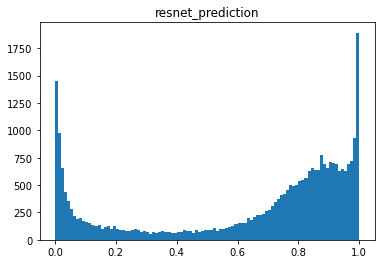

In [7]:
import numpy as np
import matplotlib.pyplot as plt

plt.hist(resnet_preds, bins=100)
plt.title('resnet_prediction')

Text(0.5, 1.0, 'log_prediction')

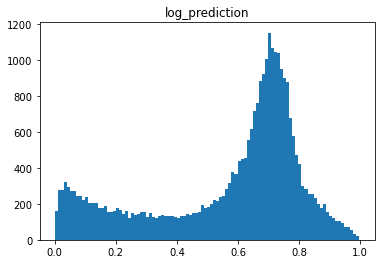

In [8]:
import numpy as np
import matplotlib.pyplot as plt

plt.hist(log_preds, bins=100)
plt.title('log_prediction')

Text(0.5, 1.0, 'resnet_prediction')

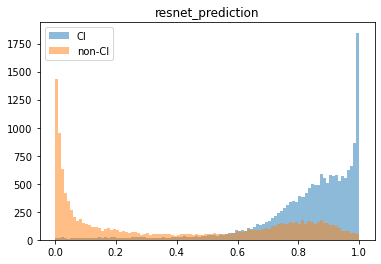

In [12]:
import numpy as np
import matplotlib.pyplot as plt

plt.hist(resnet_preds[test_label==1], alpha=0.5, label='CI', bins=100)
plt.hist(resnet_preds[test_label==0], alpha=0.5, label='non-CI', bins=100)
plt.legend()
plt.title('resnet_prediction')

Text(0.5, 1.0, 'log_prediction')

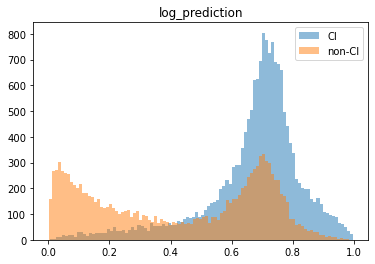

In [13]:
import numpy as np
import matplotlib.pyplot as plt

plt.hist(log_preds[test_label==1], alpha=0.5, label='CI', bins=100)
plt.hist(log_preds[test_label==0], alpha=0.5, label='non-CI', bins=100)
plt.legend()
plt.title('log_prediction')

In [64]:
# Resample data (bootstrap)
from sklearn.utils import resample
from module_4 import performance_diagrams_8
n_samples = 100
ci = (2.5, 97.5)
resnet_bootstrap_perf_diagram = np.zeros((1003,n_samples, 2))
for i in range(n_samples):
    resnet_preds_bootstrap, resnet_labels_bootstrap = resample(resnet_preds, test_label, replace=True)
    pod_by_threshold, success_ratio_by_threshold = performance_diagrams_8.get_points_in_perf_diagram(
        observed_labels=resnet_labels_bootstrap,
        forecast_probabilities=resnet_preds_bootstrap)
    resnet_bootstrap_perf_diagram[:,i,0] = pod_by_threshold
    resnet_bootstrap_perf_diagram[:,i,1] = success_ratio_by_threshold
#plt.fill(pofd_poly, pod_poly, alpha=0.5, color=colors[b])

In [112]:
#broc_curves = np.dstack([b_roc.roc_curve().values for b_roc in b_set])
pod_range = np.percentile(resnet_bootstrap_perf_diagram[:,:, 0], ci, axis=1)
sr_range = np.percentile(resnet_bootstrap_perf_diagram[:,:, 1], ci, axis=1)
pod_poly = np.concatenate((pod_range[1], pod_range[0, ::-1]))
sr_poly = np.concatenate((sr_range[1], sr_range[0, ::-1]))
pod_poly[np.isnan(pod_poly)] = 0
sr_poly[np.isnan(sr_poly)] = 1

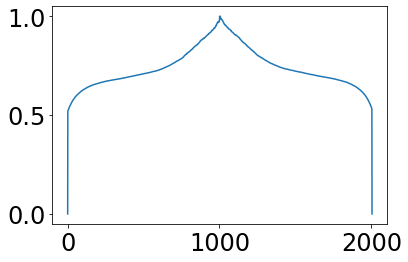

In [197]:
plt.plot(sr_poly)

In [ ]:
from module_4 import performance_diagrams_26 as performance_diagrams
POD, CSI = performance_diagrams.plot_performance_diagram(test_label,log_preds,resnet_preds, n_samples=10)#000
#plt.title('Performance diagram')
#plt.savefig('plots/Performance_diagram.png')

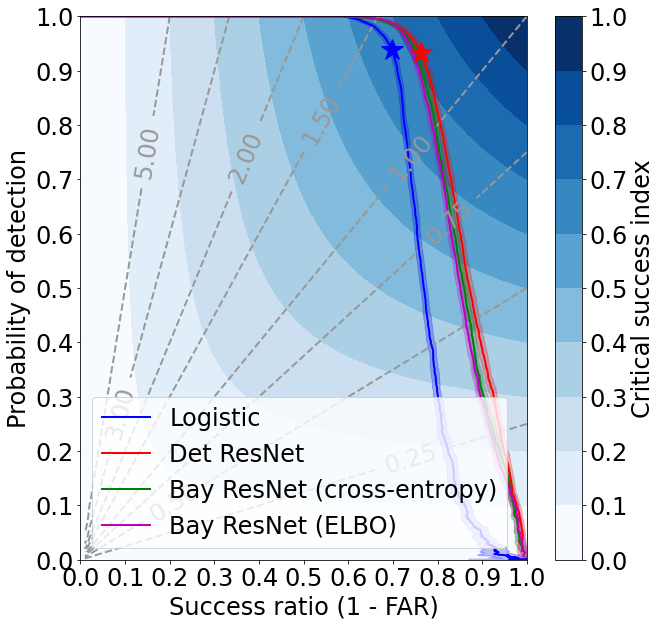

In [23]:
from module_4 import performance_diagrams_30 as performance_diagrams
POD, CSI = performance_diagrams.plot_performance_diagram(test_label,log_preds,resnet_preds,Bayesian_resnet_preds_bce,Bayesian_resnet_preds_ELBO, n_samples=100)#000
#plt.title('Performance diagram')
plt.savefig('/glade/work/fanda/plots/Performance_diagram_log_det_Bay.png')

In [5]:
import roc_utils
n_samples=1000
resnet_bootstrap = roc_utils.compute_roc_bootstrap(resnet_preds, test_label, True, n_bootstrap=n_samples, random_state=42, return_mean=False)

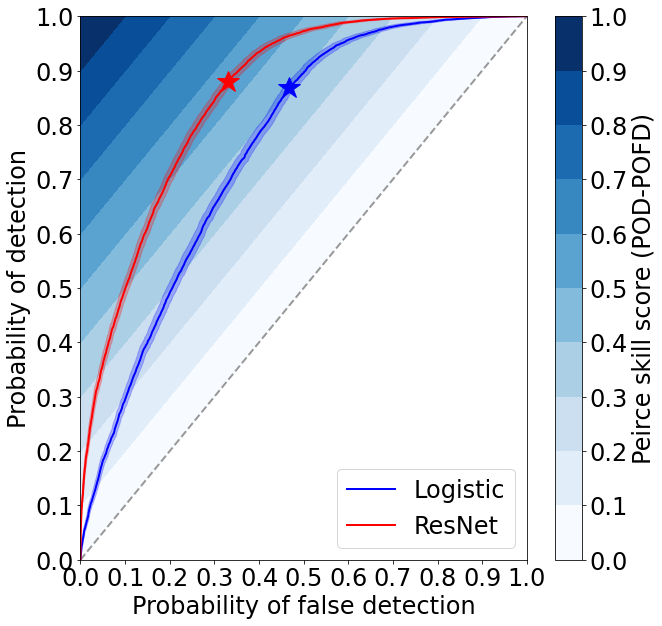

In [21]:
from module_4 import roc_curves_test11
AUC=roc_curves_test12.plot_roc_curve(test_label,log_preds,resnet_preds, n_samples=1000)#)00)
#plt.title('ROC curve')
plt.savefig('plots/ROC_curve.png')

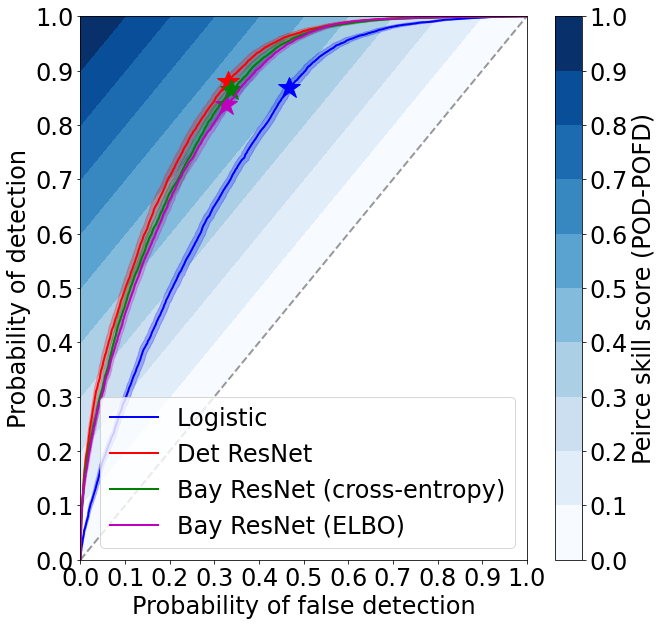

In [28]:
from module_4 import roc_curves_test14 as roc_curve
AUC=roc_curve.plot_roc_curve(test_label,log_preds,resnet_preds,Bayesian_resnet_preds_bce,Bayesian_resnet_preds_ELBO, n_samples=100)#)00)
#plt.title('ROC curve')
plt.savefig('/glade/work/fanda/plots/ROC_curve_log_det_Bay.png')

(array([0.04640556, 0.13346121, 0.22722118, 0.31827113, 0.41148075,
        0.505243  , 0.59725702, 0.67998755, 0.7630747 , 0.85919726,
        0.94219756]),
 array([0.04259502, 0.12311015, 0.24774266, 0.36807388, 0.48150289,
        0.55623209, 0.60332779, 0.667882  , 0.73963806, 0.83805031,
        0.89183223]),
 array([3052, 2315, 1772, 1516, 1730, 2792, 6010, 9051, 3426, 1272,  453]))

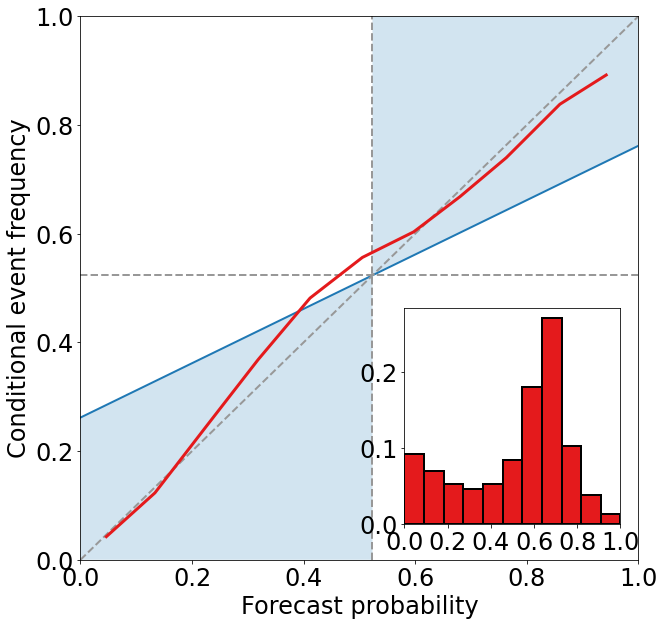

In [166]:
from module_4 import attributes_diagrams as attributes_diagrams
attributes_diagrams.plot_attributes_diagram(test_label, log_preds)

In [8]:
from module_4 import attributes_diagrams as attributes_diagrams

In [78]:
np.min(Bayesian_resnet_preds_ELBO_weighted_mean)

-49.07401608128874

0.09623147811244884
0.00197230039049108
0.38648422839566704


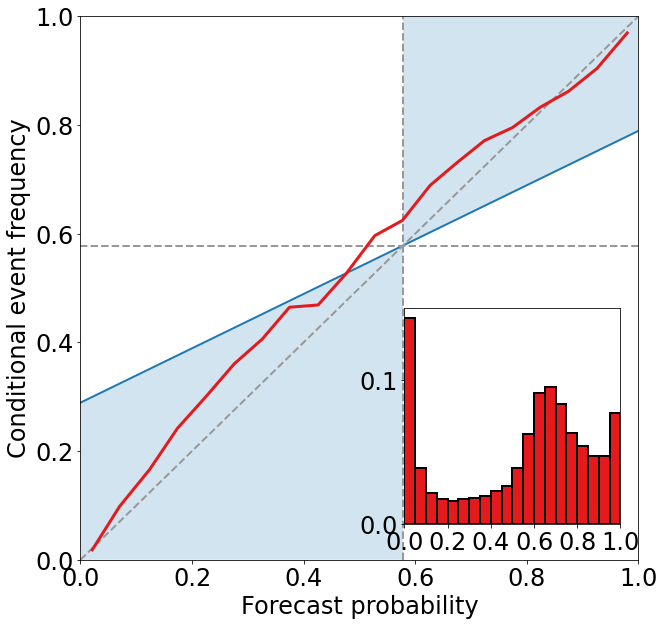

In [23]:
from module_4 import attributes_diagrams as attributes_diagrams
import scipy.io as scio
#bay_prediction = scio.loadmat('/glade/work/fanda/output_save/prediction_bayesian_resnet_KLweight_ten_len_train.mat')
bay_prediction = scio.loadmat('/glade/work/fanda/output_save/prediction_bayesian_resnet_KLweight_ten_len_train.mat')
target_values=test_label
forecast_probabilities=bay_prediction['Bayesian_resnet_preds_ELBO_mean'][0] #bay_prediction['Bayesian_resnet_preds_ELBO_mean'][0]#Bayesian_resnet_preds_ELBO#bay_prediction['Bayesian_resnet_preds_ELBO_mean'][0]#Bayesian_resnet_preds_bce_mean
mean_forecast_by_bin, event_freq_by_bin, num_examples_by_bin = (
    attributes_diagrams.plot_attributes_diagram(
        observed_labels=target_values,
        forecast_probabilities=forecast_probabilities, num_bins=20)
)

event_frequency = np.mean(target_values)
uncertainty = event_frequency * (1. - event_frequency)

this_numerator = np.nansum(
    num_examples_by_bin * (mean_forecast_by_bin - event_freq_by_bin) ** 2
)
reliability = this_numerator / np.sum(num_examples_by_bin)

this_numerator = np.nansum(
    num_examples_by_bin * (event_freq_by_bin - event_frequency) ** 2
)
resolution = this_numerator / np.sum(num_examples_by_bin)
print(resolution)
print(reliability)
# brier_score = uncertainty + reliability - resolution
brier_skill_score = (resolution - reliability) / uncertainty
print(brier_skill_score)

0.0986917178613307
0.0056623369700808685
0.3814417795786234


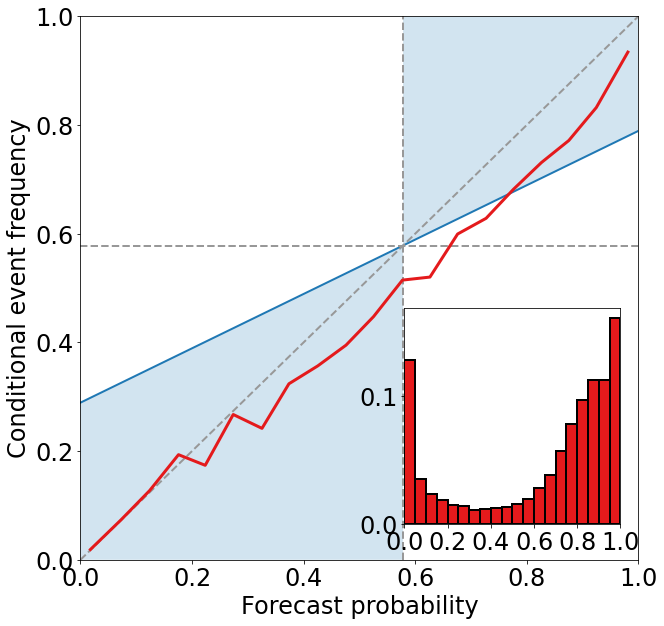

In [21]:
    target_values=test_label
    forecast_probabilities=resnet_preds
    mean_forecast_by_bin, event_freq_by_bin, num_examples_by_bin = (
        attributes_diagrams.plot_attributes_diagram(
            observed_labels=target_values,
            forecast_probabilities=forecast_probabilities, num_bins=20)
    )

    event_frequency = np.mean(target_values)
    uncertainty = event_frequency * (1. - event_frequency)

    this_numerator = np.nansum(
        num_examples_by_bin * (mean_forecast_by_bin - event_freq_by_bin) ** 2
    )
    reliability = this_numerator / np.sum(num_examples_by_bin)

    this_numerator = np.nansum(
        num_examples_by_bin * (event_freq_by_bin - event_frequency) ** 2
    )
    resolution = this_numerator / np.sum(num_examples_by_bin)
    print(resolution)
    print(reliability)
    # brier_score = uncertainty + reliability - resolution
    brier_skill_score = (resolution - reliability) / uncertainty
    print(brier_skill_score)

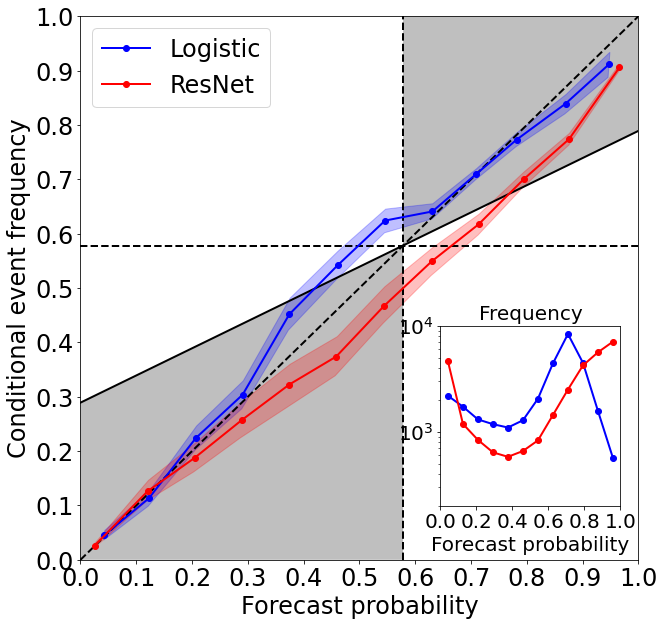

In [22]:
from module_4 import attributes_diagrams_36 as attributes_diagrams
attributes_diagrams.plot_attributes_diagram(test_label, log_preds, resnet_preds, n_samples=1000)
plt.savefig('plots/Attribute_diagram.png')

(array([0.04274749, 0.12247758, 0.20700459, 0.29056942, 0.3743324 ,
        0.46083379, 0.54600972, 0.63071179, 0.70903218, 0.78158534,
        0.86934048, 0.94722676]),
 array([0.04532967, 0.11304348, 0.22417751, 0.30364716, 0.45164234,
        0.54169914, 0.62408581, 0.64080525, 0.70938434, 0.77285938,
        0.83905852, 0.91150442]),
 array([2184, 1725, 1307, 1179, 1096, 1283, 2051, 4421, 8365, 4473, 1572,
         565]))

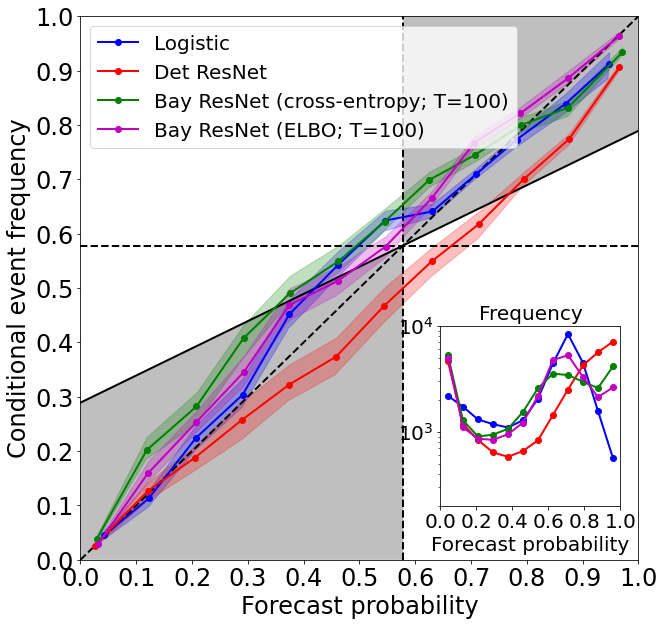

In [50]:
from module_4 import attributes_diagrams_43 as attributes_diagrams
import scipy.io as scio
bay_ELBO_prediction = scio.loadmat('/glade/work/fanda/output_save/prediction_bayesian_resnet_KLweight_eight_len_train.mat')
bay_bce_prediction = scio.loadmat('/glade/work/fanda/output_save/prediction_bayesian_resnet_bce.mat')
attributes_diagrams.plot_attributes_diagram(test_label, 
                                            log_preds, resnet_preds, bay_bce_prediction['Bayesian_resnet_preds_bce_mean'][0],
                                            bay_ELBO_prediction['Bayesian_resnet_preds_ELBO_mean'][0], n_samples=100)
#plt.savefig('/glade/work/fanda/plots/Attribute_diagram_log_det_Bay.png')

In [48]:
print(1)

1


In [55]:
from ai2es_xai_course.utils import utils

#my_model.summary()
binary_threshold = 0.31#0.54 for deterministic ResNet
preds = Bayesian_resnet_preds_ELBO_weighted_mean#np.array(bay_prediction['Bayesian_resnet_preds_ELBO_mean'][0])#Bayesian_resnet_preds_bce_mean
binary_preds = np.where(preds >= binary_threshold, 1, 0)

# Example regressed metrics
#cm = POD_score(test_label, binary_preds)
print('RMSE: {}'.format(np.round(root_mean_squared_error(test_label, preds),3)))
print('R squared: {}'.format(np.round(r2_corr(test_label, preds),3)))
print('Hellenger Distance: {}'.format(np.round(hellinger_distance(test_label, preds),3)))
POD, POFD, FAR, SR, CSI = scores(test_label, binary_preds)
print('POD: {}, POFD: {}, FAR: {}, SR: {}, CSI:{}'.format(POD, POFD, FAR, SR, CSI))
# Example classified metrics
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(test_label, binary_preds),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(test_label, binary_preds),3)))
print('Brier Score: {}'.format(np.round(brier_score(test_label, preds),3)))
#print('Brier Skill Score: {}'.format(np.round(brier_skill_score(test_label, preds),3)))
print('Accuracy score: {}'.format(np.round(accuracy_score(test_label, binary_preds),3)))
print('AUC: {}'.format(np.round(auc_score(test_label, preds),3)))

RMSE: 0.387
R squared: 0.391
Hellenger Distance: 0.542
7030 5718 841 16632
POD: 0.9518685972643507, POFD: 0.4485409475996235, FAR: 0.25583892617449666, SR: 0.7441610738255033, CSI:0.7171747660730455
Heidke Skill Score: 0.531
[[ 7030  5718]
 [  841 16632]]
Pierce Skill Score: 0.503
Brier Score: 0.15
Accuracy score: 0.783
AUC: 0.849


In [43]:
for i in np.arange(0.25,0.6,0.01):
    binary_threshold = i
    preds = np.array(bay_prediction['Bayesian_resnet_preds_ELBO_mean'][0])
    binary_preds = np.where(preds >= binary_threshold, 1, 0)
    POD, POFD, FAR, SR, CSI = scores(test_label, binary_preds)
    print('threshold: {}'.format(i))
    print('POD: {}, POFD: {}, FAR: {}, SR: {}, CSI:{}'.format(POD, POFD, FAR, SR, CSI))

6431 6317 539 16934
threshold: 0.25
POD: 0.9691524065701368, POFD: 0.49552871038594287, FAR: 0.2716872392585265, SR: 0.7283127607414734, CSI:0.7118116855821773
6500 6248 568 16905
threshold: 0.26
POD: 0.9674927030275282, POFD: 0.49011609664261063, FAR: 0.26985703796484256, SR: 0.7301429620351574, CSI:0.7126596686480334
6567 6181 595 16878
threshold: 0.27
POD: 0.9659474617982029, POFD: 0.4848603702541575, FAR: 0.26805152001387744, SR: 0.7319484799861226, CSI:0.7135368225247315
6644 6104 627 16846
threshold: 0.28
POD: 0.9641160647856694, POFD: 0.47882020709130846, FAR: 0.2659694989106754, SR: 0.7340305010893247, CSI:0.7145099037197269
6699 6049 657 16816
threshold: 0.29000000000000004
POD: 0.9623991300864191, POFD: 0.4745058048321305, FAR: 0.26455280997157227, SR: 0.7354471900284277, CSI:0.714905195136468
6749 5999 691 16782
threshold: 0.30000000000000004
POD: 0.960453270760602, POFD: 0.4705836209601506, FAR: 0.2633334796540977, SR: 0.7366665203459023, CSI:0.7149795501022495
6813 5935 72

In [52]:
# Metric functions
from sklearn.metrics import confusion_matrix, mean_squared_error, brier_score_loss, roc_auc_score, accuracy_score

import numpy as np

def calc_pdf_hist(x, x_bins):
    return np.histogram(x, x_bins, density=True)[0]

def auc_score(y_true, y_pred):
    return roc_auc_score(y_true, y_pred)

def brier_score(y_true, y_pred):
    return brier_score_loss(y_true, y_pred)

def brier_skill_score(y_true, y_pred):
    
    model_brier_score = mean_squared_error(y_true, y_pred)
    climo_brier_score = mean_squared_error(y_true, np.ones(y_true.size) * y_true.sum() / y_true.size)
    model_brier_skill_score = 1 - model_brier_score / climo_brier_score
    return model_brier_skill_score

def hellinger(x, pdf_p, pdf_q):
    pdf_distances = (np.sqrt(pdf_p) - np.sqrt(pdf_q)) ** 2
    return np.trapz(pdf_distances, x) / 2

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def hellinger_distance(y_true, y_pred, bins=50):
    bin_points = np.linspace(np.minimum(y_true.min(), y_pred.min()),
                       np.maximum(y_true.max(), y_pred.max()),
                       bins)
    bin_centers = 0.5 * (bin_points[:-1] + bin_points[1:])
    y_true_pdf = calc_pdf_hist(y_true, bin_points)
    y_pred_pdf = calc_pdf_hist(y_pred, bin_points)
    return hellinger(bin_centers, y_true_pdf, y_pred_pdf)

def scores(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    C, F, M, H = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
    print(C, F, M, H)
    POD = H/(H+M)
    POFD = F/(F+C)
    FAR = F/(F+H)
    SR = H/(F+H)
    CSI = H/(H+F+M)
    return POD, POFD, FAR, SR, CSI

def scores_new(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    C, F, M, H = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
    print(C, F, M, H)
    POD = H/(H+M)
    POFD = F/(F+C)
    FAR = F/(F+H)
    SR = H/(F+H)
    CSI = H/(H+F+M)
    return C, F, M, H, POD, POFD, FAR, SR, CSI

#tn, fp, fn, tp
def peirce_skill_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    n = float(cm.sum())
    nf = cm.sum(axis=0)
    no = cm.sum(axis=1)
    correct = float(cm.trace())
    return (correct / n - (nf * no).sum() / n ** 2) / (1 - (no * no).sum() / n ** 2)

def heidke_skill_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    n = float(cm.sum())
    nf = cm.sum(axis=0)
    no = cm.sum(axis=1)
    correct = float(cm.trace())
    return (correct / n - (nf * no).sum() / n ** 2) / (1 - (nf * no).sum() / n ** 2)

def r2_corr(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0, 1] ** 2

In [19]:
bin_frequencies = np.array([2826, 2200, 1668, 1450, 1447, 1922, 3553, 7270, 7251, 2343, 1065,394])

In [59]:
print(1e2)

100.0


In [14]:
forecast_bin_edges = np.linspace(0, 1, num=12 + 1, dtype=float)
forecast_bin_width = forecast_bin_edges[1] - forecast_bin_edges[0]
forecast_bin_centers = forecast_bin_edges[:-1] + forecast_bin_width / 2

In [20]:
HISTOGRAM_Y_TICK_SPACING = 0.1

def _floor_to_nearest(input_value_or_array, increment):
    """Rounds number(s) down to the nearest multiple of `increment`.

    :param input_value_or_array: Input (either scalar or numpy array).
    :param increment: Increment (or rounding base -- whatever you want to call
        it).
    :return: output_value_or_array: Rounded version of `input_value_or_array`.
    """

    return increment * np.floor(input_value_or_array / increment)

max_y_tick_value = _floor_to_nearest(
    1.05 * np.max(bin_frequencies), HISTOGRAM_Y_TICK_SPACING)
num_y_ticks = 1 + int(np.round(
    max_y_tick_value / HISTOGRAM_Y_TICK_SPACING
))

In [42]:
bin_frequencies

array([2826, 2200, 1668, 1450, 1447, 1922, 3553, 7270, 7251, 2343, 1065,
        394])

([<matplotlib.axis.YTick at 0x2aaedac2f890>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

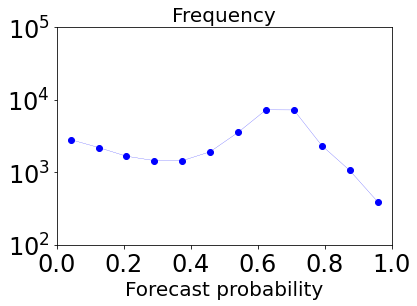

In [47]:
import matplotlib.pyplot as pyplot
pyplot.plot(forecast_bin_centers, bin_frequencies, color='b',marker='o',linestyle='solid', linewidth=0.2)
pyplot.xlim(0, 1)
pyplot.ylim(100, int(10000))
pyplot.yscale('log')
pyplot.xlabel('Forecast probability', fontsize=20)
pyplot.title('Frequency', fontsize=20)
pyplot.xticks(np.arange(0, 1.1, 0.2))
pyplot.yticks([10e1,10e2,10e3,10e4])
##inset_axes_object.set_yticks(numpy.arange(0, 0.21, 0.05))
#pyplot.xticklabels([str(round(i,2)) for i in np.arange(0.0, 1.1, 0.2)], fontsize=20)

In [36]:
int(1.05 * np.max(bin_frequencies))

7633